###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Assignment 1: Music genre classification with naive Bayes


**Student ID(s):**     `1268470`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [115]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, accuracy_score, recall_score

def log_gaussian(param, x):
    mu = param['mu']
    sd = param['sd']
    return -np.log(sd)-1/2*np.log(2)-1/2*np.log(np.pi)-(x - mu)**2 / 2 / sd**2

In [85]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing

def preprocess(file_name):
    file = pd.read_csv(file_name+'.csv', sep=',')
    data = file.iloc[:, 1:-1] # exclude the first column, filename, & labels
    labels = file['label'] # label column
    return data, labels

In [4]:
# This function should calculat prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

def calc_prior(labels):
    prior_prob = {}
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    n = len(labels)
    for i in range(len(unique_labels)):
        prior_prob[unique_labels[i]] = (label_counts[i] / n)
    return prior_prob

In [5]:
def calc_likelihoods(data, labels):
    unique_labels = np.unique(labels) # set of labels
    features_list = data.columns # the name of the features, ensuring to exclude label*
    likelihood = {}
    
    for feature in features_list:
        likelihood[feature] = {}
        for label in unique_labels:
            values = data.loc[labels==label, feature]
            likelihood[feature][label] = {'mu': np.mean(values), 'sd': np.std(values, ddof=1)}
            # find all values for a certain feature with class == label, then record the mean and standard deviation
            
    return likelihood
    

In [6]:
def train(data, labels):
    prior_prob = calc_prior(labels) # dictionary: keys the label & value the corresponding prior probability
    likelihoods = calc_likelihoods(data, labels) # dictionary: first key the feature, second key the label then the mu & sd
    return prior_prob, likelihoods

In [7]:
def calc_posterior(data, prior_prob, likelihood):
    posterior_probs = []

    for _, instance in data.iterrows():
        post_probs = {}
        for label in prior_prob:
            post_probs[label] = np.log(prior_prob[label])
            for feature in likelihood:
                    post_probs[label] += log_gaussian(likelihood[feature][label], instance[feature])
        posterior_probs.append(post_probs)

    return posterior_probs

In [8]:
# This function should predict classes for new items in a test dataset

def predict(data, prior_prob, likelihood, calc_pos):
    # Calculate posterior probabilities
    posterior_probs = calc_pos(data, prior_prob, likelihood)
    # Find argmax for each instance
    predictions = [max(probs, key=probs.get) for probs in posterior_probs]
    return predictions

In [9]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels

def evaluate(predictions, true):
    return accuracy_score(true, predictions)

In [10]:
def diagnostics(predictions, true):
    pos = 'classical'
    neg = 'pop'
    labels_l = [pos, neg]
    conf_matrix = confusion_matrix(true, predictions, labels=labels_l)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels_l)
    disp.plot(colorbar=False, cmap='binary')
    plt.title('Confusion matrix of the Naive Bayes classifier')
    plt.show()
    tp, fn, fp, tn = conf_matrix.ravel()
    print((tp, fp, fn, tp))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print("precision: ",precision)
    print("recall: ", recall)
    print("accuracy: ", evaluate(predictions, true))

## Task 1. Pop vs. classical music classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q1
Compute and report the accuracy, precision, and recall of your model (treat "classical" as the "positive" class).

In [27]:
data_train, labels_train = preprocess('pop_vs_classical_train')
prior_prob, likelihood = train(data_train, labels_train)

data_test, labels_test = preprocess('pop_vs_classical_test')
predictions = predict(data_test, prior_prob, likelihood, calc_posterior)


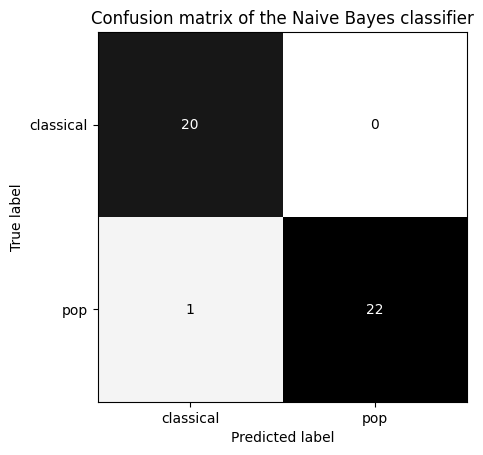

(20, 1, 0, 20)
precision:  0.9523809523809523
recall:  1.0
accuracy:  0.9767441860465116


In [28]:
diagnostics(predictions, labels_test)

### Q2
For each of the features X below, plot the probability density functions P(X|Class = pop) and P(X|Class = classical). If you had to classify pop vs. classical music using just one of these three features, which feature would you use and why? Refer to your plots to support your answer.
- spectral centroid mean
- harmony mean
- tempo

In [29]:
features = ['spectral_centroid_mean', 'harmony_mean', 'tempo']
labels = ['pop', 'classical']

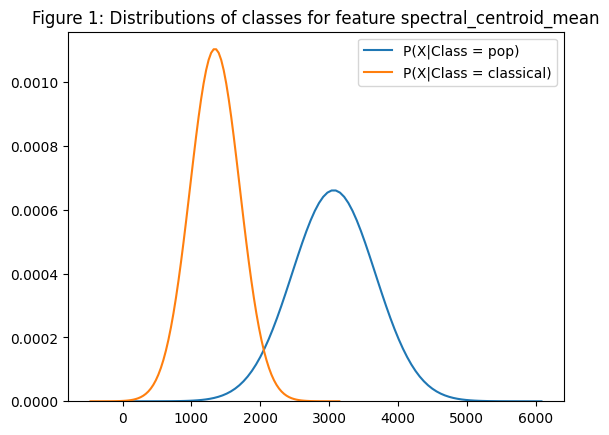

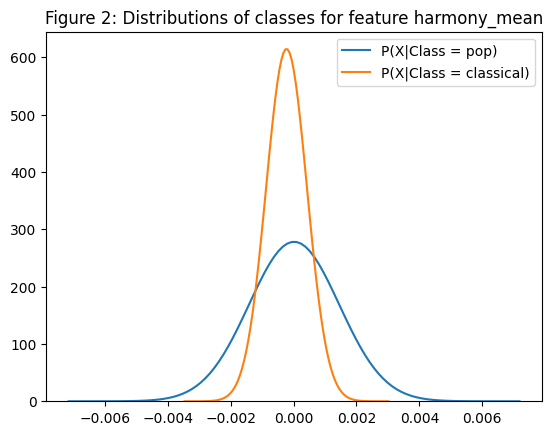

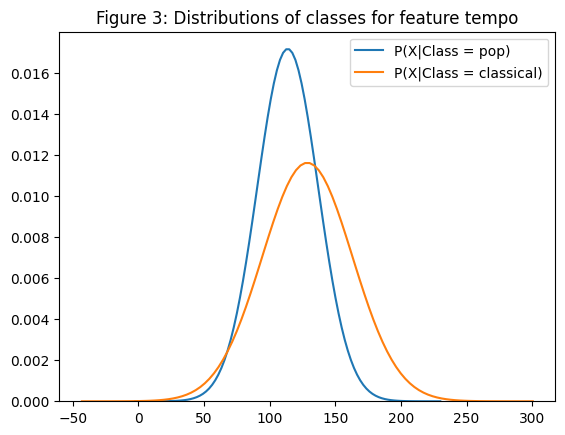

In [30]:
for feat in features:
    for lab in labels:
        mu = likelihood[feat][lab]['mu']
        sd = likelihood[feat][lab]['sd']
        x = np.linspace(mu - 5*sd, mu + 5*sd, 100)
        plt.plot(x, norm.pdf(x, mu, sd))
    plt.title("Figure {}: Distributions of classes for feature {}".format(features.index(feat)+1,feat))
    plt.legend(["P(X|Class = {})".format(lab) for lab in labels])
    ylim = plt.gca().get_ylim()
    plt.ylim([0, ylim[1]])
    plt.show()

## Task 2. 10-way music genre classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

In [11]:
data_train, labels_train = preprocess('gztan_train')
prior_prob, likelihood = train(data_train, labels_train)

data_test, labels_test = preprocess('gztan_test')
predictions = predict(data_test, prior_prob, likelihood, calc_posterior)

In [120]:
def eval_multimodel(labels_test, predictions, accuracy_data, recall_data, precision_data):
    unique_labels = list(set(predictions).union(set(labels_test))) # what if we never predict a label?
    for i, label in enumerate(unique_labels):
        bin_true = np.array(labels_test) == label
        bin_predict = np.array(predictions) == label
        accuracy_data[i].append(accuracy_score(bin_true, bin_predict))
        recall_data[i].append(recall_score(bin_true, bin_predict))
        precision_data[i].append(precision_score(bin_true, bin_predict))
    accuracy_data[-1].append(accuracy_score(labels_test, predictions))

### Q6
Modify your naive Bayes model to handle missing attributes in the test data. Recall from lecture that you can handle missing attributes at test by skipping the missing attributes and computing the posterior probability from the non-missing attributes. Randomly delete some attributes from the provided test set to test how robust your model is to missing data. In your write-up, evaluate how your model's performance changes as the amount of missing data increases.

In [14]:
def calc_posterior_task2(data, prior_prob, likelihood):
    posterior_probs = []
    for _, instance in data.iterrows():
        post_probs = {}
        for label in prior_prob:
            post_probs[label] = np.log(prior_prob[label])
        for feature in likelihood:
            if not pd.isna(instance.loc[feature]):
                for label in prior_prob:
                    post_probs[label] += log_gaussian(likelihood[feature][label], instance[feature])
        posterior_probs.append(post_probs)

    return posterior_probs

In [140]:
def create_deleted_csv(deletion_percent, file_name, i):
    file = pd.read_csv(file_name+'.csv', sep=',')
    start_col = 1
    end_col = len(file.columns) - 2
    numRows = file.shape[0]
    to_delete = round(numRows*end_col*deletion_percent)

    if deletion_percent > 1:  # if we are to delete more than 50%, quicker considering the % to keep
        to_keep = numRows*end_col - to_delete
        df = pd.DataFrame(index=range(numRows),columns=file.columns)
        rand_list = list(np.random.randint(low=[0,start_col],high=[numRows, end_col],size=[to_keep, 2]))
        while rand_list:
            new = rand_list.pop(0)
            if not pd.isna(df.iloc[new[0], new[1]]):
               rand_list.append(np.random.randint(low=[0,start_col],high=[numRows, end_col]))
            else:
                df.iloc[new[0], new[1]] = file.iloc[new[0], new[1]]
        file = df
    else:
        rand_list = list(np.random.randint(low=[0,start_col],high=[numRows, end_col],size=[to_delete, 2]))
        while rand_list:
            new = rand_list.pop(0)
            if pd.isna(file.iloc[new[0], new[1]]):
               rand_list.append(np.random.randint(low=[0,start_col],high=[numRows, end_col]))
            else:
                file.iloc[new[0], new[1]] = pd.NA
    os.makedirs('./{}/{}'.format(file_name, deletion_percent), exist_ok=True)
    file.to_csv('./{}/{}/test{}.csv'.format(file_name, deletion_percent, i), index = False)
    return file.iloc[:, 1:-1], file['label']

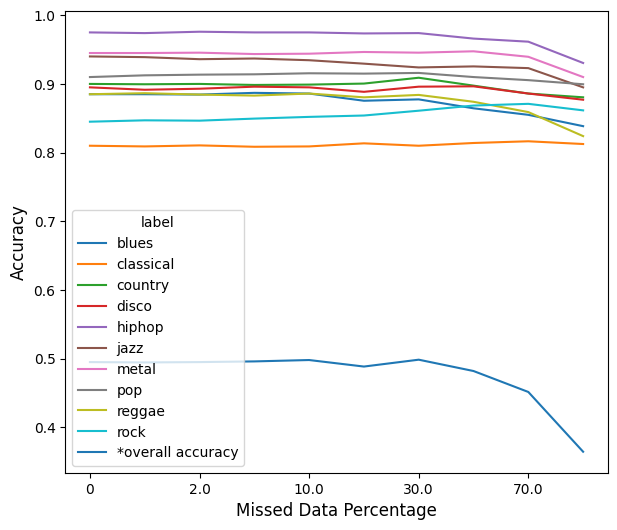

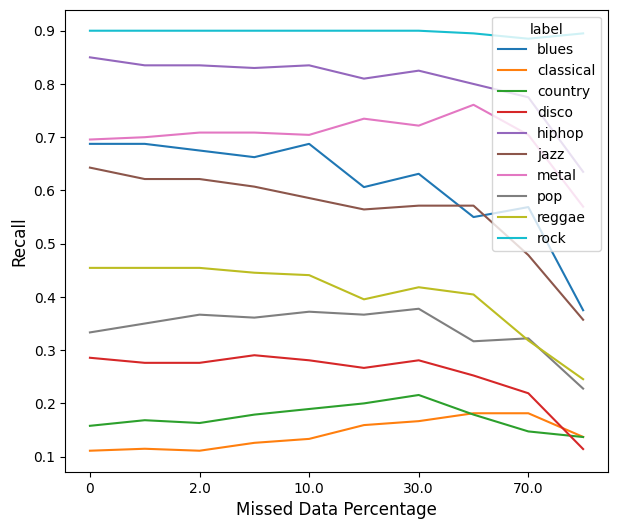

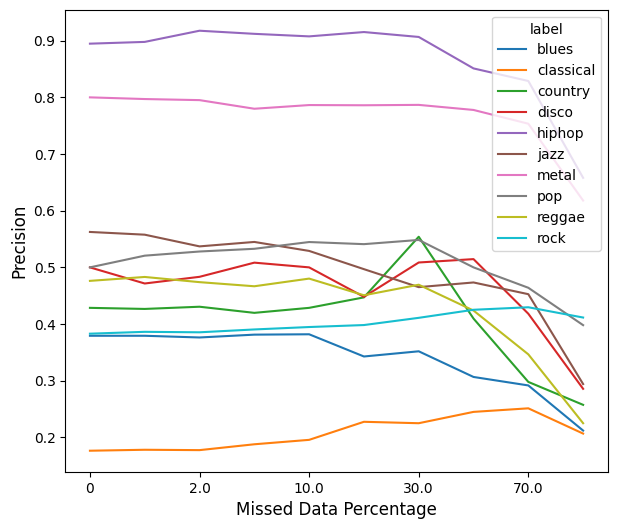

In [145]:
del_percent_list = np.array([0.01, 0.02, 0.05, 0.10, 0.20, 0.30, 0.50, 0.70, 0.90])
n_runs = 10
data_train, labels_train = preprocess('gztan_train')
prior_prob, likelihood = train(data_train, labels_train)

data_test, labels_test = preprocess('gztan_test')
predictions = predict(data_test, prior_prob, likelihood, calc_posterior)

plots = ['Accuracy', 'Recall', 'Precision']
accuracy_data = []
recall_data = []
precision_data = []
classes = np.unique(labels_train)
for label in classes:
    accuracy_data.append([label])
    recall_data.append([label])
    precision_data.append([label])
accuracy_data.append(['*overall accuracy'])
eval_multimodel(labels_test, predictions, accuracy_data, recall_data, precision_data)

for percent in del_percent_list:
    y_predicted = []
    y_true = []
    for i in range(n_runs):
        data_test, labels_test = create_deleted_csv(percent, 'gztan_test', i)
        y_true += list(labels_test)
        y_predicted += predict(data_test, prior_prob, likelihood, calc_posterior_task2)
    eval_multimodel(y_true, y_predicted, accuracy_data, recall_data, precision_data)


for i, data in enumerate([accuracy_data, recall_data, precision_data]):
    df = pd.DataFrame(data, columns = ['label', 0]+list(np.multiply(del_percent_list,100))).set_index('label')
    ax = df.T.plot(figsize=(7, 6))
    ax.set_ylabel(plots[i], fontsize=12)
    ax.set_xlabel('Missed Data Percentage', fontsize=12)
    plt.show()

(     chroma_stft_mean  chroma_stft_var  rms_mean   rms_var   
 0            0.340914         0.094980  0.095948  0.002373  \
 1            0.404785         0.093999  0.141093  0.006346   
 2            0.303993         0.094703  0.142865  0.009200   
 3            0.304186         0.098493  0.081472  0.002641   
 4                 NaN         0.095015  0.077110  0.005946   
 ..                ...              ...       ...       ...   
 195          0.255701         0.090605       NaN  0.001484   
 196          0.389313              NaN  0.101960  0.000372   
 197          0.398687              NaN  0.076458  0.000588   
 198          0.432142         0.075268  0.081651  0.000322   
 199          0.358401         0.085884       NaN  0.000336   
 
      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean   
 0               1530.176679          375850.073649              2039.036516  \
 1               1070.106615          184355.942417              1596.412872   
 2